# Milestone 6 - Implementing Neural Style Transfer

__Objective__: Use Artificial Intelligence to create art using the Neural Style Transfer algorithm that was introduced by Gatys et al. in their 2015 paper titled, ‘A Neural Algorithm of Artistic Style’. We will be applying the artistic style from an image (we’ll call this the style image) to another image (our content image). We will be performing this style transfer using a 3-component loss function that includes the Content Loss, Style Loss, and the Total Variation Loss

__Notes__:
- Recall from earlier lessons that within the space of a pretrained CNN, there is stored ‘knowledge’ known as the latent space. The filters of pretrained CNNs are hierarchical learners which means the lower layers store information relating to simple local information such as blobs, colors, edges, etc. Mid-tier layers capture a combination of things from lower layers to recognize corners and simple shapes. The upper layers capture more complex patterns and abstract features. 
- It is advised you use Keras instead of the Keras included with TensorFlow 2.0.
- Use the requirements.txt file attached


__Workflow__:

1. Let’s start developing the intuition for our loss functions. We first need to develop a Content Loss function. 
    - In order to preserve the contour lines and spatial layouts of our content image, if we propagate our image through a pretrained CNN and look at the activations of the upper or higher layers, it should activate on well defined/recognizable abstract qualities in the image. 
Y    - ou will need to compute the activation of a specific upper layer, for instance, if using VGG19 (recommended), you can utilize the filter named, `block4_conv2` for both your content and style images.
    - Compute the L2-norm (sum of squared differences) between these activations. The content loss is the L2-norm between the features of our input image and the features of the generated, output image.
    - Our Content Loss function’s aim is to ensure the output generated image will have some similarity to the content image.
2. Let’s develop the intuition behind our Style loss. Instead of a single upper layer, we will utilize multiple layers of our pretrained CNN to obtain our style loss function. This is because we wish to capture multi-scale representations and textures from our style image. This allows us to capture the local style and avoid capturing global arrangements.
    - We use multiple layers for example (if using VGG19) `['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'Block5_conv1']
    - Our goal during training is to minimize the loss between the style of our generated image and the style of our style image. This ensures that the style of our generated images is correlated to the style of the style image. 
    - In order to build this style loss function, we need to compute the correlations between the activation layers of our selected CNN filters. To do this we compute the Gram Matrix between the activations of these layers. A Gram matrix is the inner product of a set of features maps.
3. Build a function that returns the Gram Matrix. The Gram Matrix in our case is the dot product between the input vectors (feature maps) and their transpose. This can be built by:
    - Flattening the input features using `features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))`
    - Then finding the dot product with its transpose. This can be done with the Keras backend function shown here: `gram = K.dot(features, K.transpose(features))`
    - Computing the L2 norm allows us to force our generated output image to have similar style characteristics, but not necessarily the same structural contents, as the style image.
4. We finally get to our third loss function, the Total-Variation loss which now operates only on the output image. This function was not part of the original paper by Gatys et al. but was introduced later on due to better spatial smoothness in the output image (i.e. more locally coherent).  It’s effectively a measure of noise in an image and thus by lowering its loss, we make more aesthetically appealing images. To obtain the Total Variation loss, you will need to:
    - Shift the image one pixel to the right and calculate the sum of squared error between the transferred and original. 
    - To square our tensors we can use the Keras backend function `k.square` and to get the sum we can use `k.sum`
    - Then we do this again by we shift the image one pixel down this time
5. Now you can combine all three loss functions to obtain one single loss function to minimize:
    - This is given as `total_loss = [style(style_image) - style(generated_image)] + [content(original_image) - content(generated_image)] + total_variation_loss`
6. Now that you have loss functions, let’s start putting together some helper utility functions to implement Neural Style Transfer
    - Create a `pre_process_image()` function that takes the image or input path to an image as its argument and outputs an image using the `vgg19.preprocess_input()` function.
    - Create a `deprocess_image()` function that removes the zero-center by mean pixel and clips the output values between 0 and 255
7. Define two Keras variables to store our content and style images to get the tensor representations of our images.
    - Use the Keras backend function `K.variable` to get the tensor representation
    - Create a placeholder for our generated output image using `K.placeholder((1, img_nrows, img_ncols, 3))`
8. Combine the three images into one single input tensor using `K.concatenate()`.
9. Load the pretrained (imagenet)  VGG19 network using our input tensor (i.e. our 3 images) as the input without loading the top of the network.
10. Select your network layer you will be using for your Content Loss.  We use upper layers so that high-level features are represented so selecting `block5_conv2` for instance would be a good choice.  Get the symbolic outputs of each key layer like this:
    - `outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])`
    - Get the single  `layer_features = outputs_dict['block5_conv2']`
11. Now we can extract the features from the layer that we chose from the input tensor like this:
    - `content_image_features = layer_features[0, :, :, :]`
    - `combined_features = layer_features[2, :, :, :]`
12. Finally, we loop through these feature_layers to calculate the style loss.
13. We now need to create a way to get the gradients of the generated image with respect to the loss.
    - You can use Keras’s `K.gradients` and `k.function` to build this.
    - After which create a simple function called `eval_loss_and_grads` that will  return the loss and gradients

14. Create a class called `evaluator` that contains methods that calculate the overall loss and gradients as described previously. This is needed so that we can compute our  loss and gradients in one pass while retrieving them via two separate functions, `loss` and `grads`. This is done because scipy.optimize  requires separate functions for loss and gradients, but computing them separately would be inefficient.

15. All our building blocks are now in place to implement the Neural Style Transfer Algorithm. However, we can fine-tune the weightings of the contribution of the style and content images by using some weighting parameters. These are multiplied by each type of loss. They are the `content_weight`, `total_variation_weight` and the `style_weight`.

16. Start iteratively minimize our total loss function using the scipy-based optimization method called `scipy.optimize.fmin_l_bfgs_b`.
    - To be track on this training process for each iteration print out some logging information such as the Iteration no. and  the loss 
    - Display your Neural Style Transfer generated image the end
17. Experiment with different weighting combinations, different layers, number of iterations and of course changing your content and style images to create amazing AI-generated art using NST!


In [5]:
# Import our modules. Note we use keras and not the TensorFlow2.0 keras
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time


# Import our VGG19 model
from keras.applications import vgg19
from keras import backend as K

Using TensorFlow backend.


### Download our style and base images

--2020-06-16 16:13:37--  https://i.imgur.com/GwoGyMl.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.52.193
Connecting to i.imgur.com (i.imgur.com)|151.101.52.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 321995 (314K) [image/jpeg]
Saving to: ‘style_image.jpg’

style_image.jpg     100%[===================>] 314.45K  --.-KB/s    in 0.03s   

2020-06-16 16:13:37 (9.07 MB/s) - ‘style_image.jpg’ saved [321995/321995]

--2020-06-16 16:13:39--  https://i.imgur.com/UCDA6NR.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.52.193
Connecting to i.imgur.com (i.imgur.com)|151.101.52.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115057 (112K) [image/jpeg]
Saving to: ‘base_image.jpg’

base_image.jpg      100%[===================>] 112.36K  --.-KB/s    in 0.02s   

2020-06-16 16:13:39 (5.09 MB/s) - ‘base_image.jpg’ saved [115057/115057]



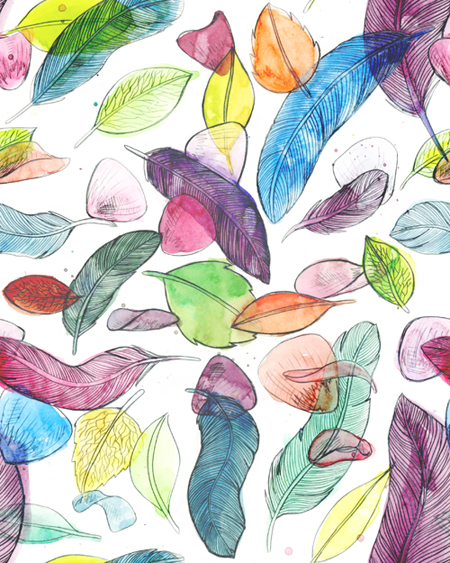

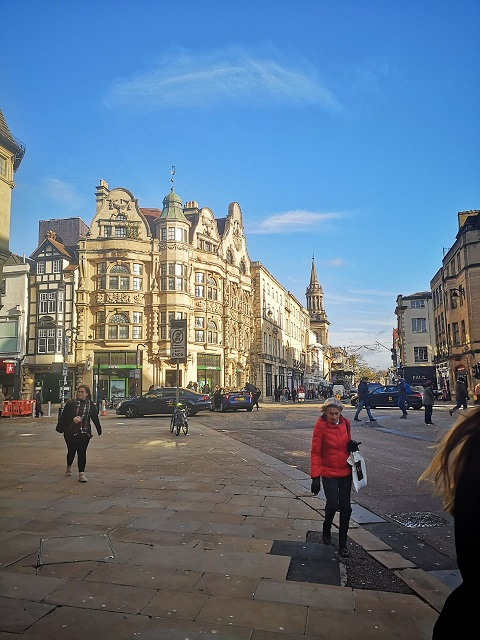

In [6]:
!wget -O style_image.jpg https://i.imgur.com/GwoGyMl.jpg #Download Features Style Image
#!wget -O style_image.jpg https://i.imgur.com/UkgSWFV.jpg #Download Candy Style Image
#!wget -O style_image.jpg https://i.imgur.com/ivOAEV1.jpg #Download Mosaic Style Image

!wget -O base_image.jpg https://i.imgur.com/UCDA6NR.jpg #Download Base Image

from google.colab.patches import cv2_imshow
import cv2

style = cv2.imread('style_image.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(style)
base = cv2.imread('base_image.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(base)

In [0]:
# Point to our image paths for our content/base image and style images
base_image_path = 'base_image.jpg'
style_reference_image_path = 'style_image.jpg'
result_prefix = "output_"

### These are the weights of the different loss components

In [0]:
# Also, higher total_variation_weight implies higher spatial smoothness.
total_variation_weight = 1
style_weight = 1
content_weight = 0.5

#### Set the dimensions of the generated image

In [0]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

#### Preprocess Utility Function 

In [0]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

#### Deprocess Utility Function 

In [0]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### Convert out images to tensor representations

In [0]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

#### Examine what a tensor looks like

In [13]:
# Examine our tensor shape
base_image.shape

TensorShape([1, 400, 300, 3])

#### Create a blank placehold image to hold our output image

In [0]:
# this will contain our generated image
generated_image = K.placeholder((1, img_nrows, img_ncols, 3))

#### Combine the 3 images into a single Keras tensor 

In [0]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image, style_reference_image, generated_image], axis=0)

### Load our pretrained VGG19 without the head and the toplayer

In [16]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 2s 0us/step
Model loaded.


#### Understand how we get the layer names and how we create a dictionary of layer names as the key and the outputs of layer as the key

In [17]:
# We can extract the model names using the .name method to access it
print(model.layers[2].name)

# Likewise you can do the same for the  can extract the model output
print(model.layers[2].output)

block1_conv2
Tensor("block1_conv2/Relu:0", shape=(3, 400, 300, 64), dtype=float32)


In [0]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [19]:
# Examine what the dictionary stores
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 300, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 300, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 150, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 150, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 150, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 75, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 75, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 75, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 75, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 75, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 37, 256) dtype=float32>,
 'bloc

# The Gram Matrix function

In [0]:
# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# The Style Loss function

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# The Content Loss function

In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# The Total Variation Loss function

In [0]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Selet the Filter we'll be using for our Content Loss

In [0]:
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv1']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features, combination_features)

## Select the filters you wish to use to build your Gram Matrix required for our Style Loss Function

In [0]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

### We loop through these feature_layers to calculate the style loss

In [0]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    # style loss is scaled by a weighting parameter and the number
    # of layers that it is calculated over  
    loss = loss + (style_weight / len(feature_layers)) * sl
    
loss = loss + total_variation_weight * total_variation_loss(generated_image)

#### We obtain the gradients of the generated image for the respective loss, and then use it to create a tensor function that returns the gradients 

In [0]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, generated_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([generated_image], outputs)

#### We use this function in the Evaluator class defined below so that we can compute our  loss and gradients in one pass while retrieving them via two separate functions, `loss` and `grads`. This is done because scipy.optimize  requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

# We can now implement our Neural Style Transfer Algorithm!

Start of iteration 0
Image saved as output__at_iteration_0.png Iteration 0 completed in 8s. Current loss value: 10895047680
Start of iteration 1
Image saved as output__at_iteration_1.png Iteration 1 completed in 2s. Current loss value: 6853633024
Start of iteration 2
Image saved as output__at_iteration_2.png Iteration 2 completed in 2s. Current loss value: 5705351168
Start of iteration 3
Image saved as output__at_iteration_3.png Iteration 3 completed in 2s. Current loss value: 5171899392
Start of iteration 4
Image saved as output__at_iteration_4.png Iteration 4 completed in 2s. Current loss value: 4838802432
Start of iteration 5
Image saved as output__at_iteration_5.png Iteration 5 completed in 2s. Current loss value: 4598416896
Start of iteration 6
Image saved as output__at_iteration_6.png Iteration 6 completed in 2s. Current loss value: 4427070464
Start of iteration 7
Image saved as output__at_iteration_7.png Iteration 7 completed in 2s. Current loss value: 4301366784
Start of iterat

<Figure size 432x288 with 0 Axes>

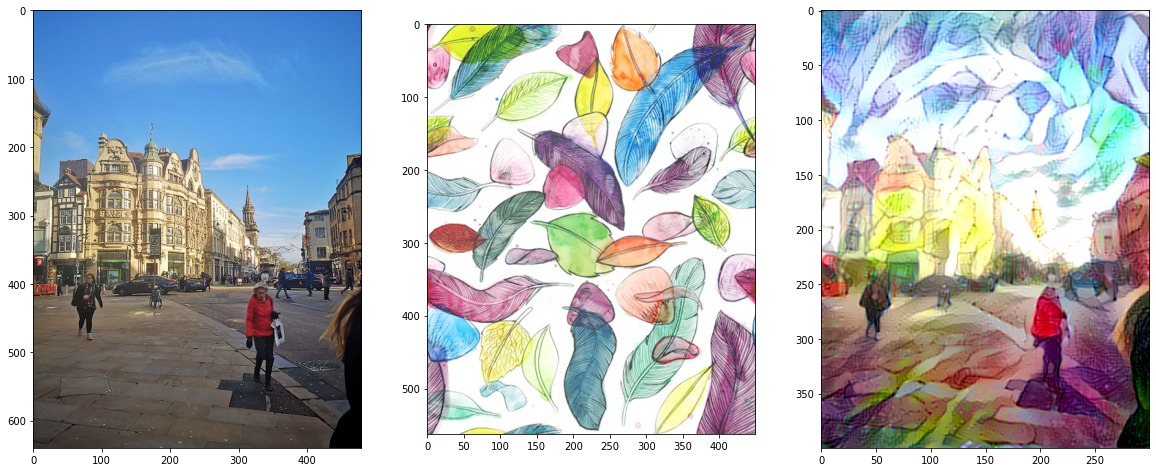

In [30]:
import matplotlib.pyplot as plt

# Specify Iterations to run
iterations = 100

# Enlarge figure view when displaying final output
fig = plt.figure()
plt.figure(figsize=(20,20))

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x.flatten(),
                                     fprime=evaluator.grads,
                                     maxfun=20)
    # save current generated image after deprocessing
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as %s Iteration %d completed in %ds. Current loss value: %d' % (fname, i, end_time - start_time, min_val))

# Display our images
print('Output Generation Completed after %d Iterations' % i)
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.subplot(1, 3, 1)
base = plt.imread('base_image.jpg')
plt.imshow(base)
style = plt.imread('style_image.jpg')
plt.subplot(1, 3, 2)
plt.imshow(style)

__Summary__:

In this notebook we:
- Loaded a pretrained (imagenet) VGG19 model without its top layer and used it to implement the Neural Style Transfer Algorithm.
- We created 3 loss function, content loss, style loss, and total variance loss and combined them into a single loss function that was minimized in order to produce a generated image that copied the style of our style image onto our content image. 

__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow as you create your loss functions and then combine them using the recommended Keras functions. You are then to load your own content and style images and implement the Neural Style Transfer algorithm to create your own Art. Create a few different variations of your Art using different layers and weighting parameters. 
